<a href="https://colab.research.google.com/github/la2015-hw/Group_10/blob/main/MLP_morphology_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!pip install kaggle --quiet

In [3]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mustansireranpurwala/sdss-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.48G/9.48G [01:06<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/7


In [4]:
import h5py
import numpy as np
import os

# Use the KaggleHub download path
import kagglehub
dataset_path = "/root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/7/processed_sdss_balanced.h5"


print("Path to dataset file:", dataset_path)

# Inspect file
with h5py.File(dataset_path, "r") as f:
    print("Keys in HDF5 file:", list(f.keys()))
    for key in f.keys():
        print(f"{key}: shape={f[key].shape}, dtype={f[key].dtype}")

# Extract features and labels
with h5py.File(dataset_path, "r") as f:
    # Target label
    y = np.array(f["broad_class"][:]).astype(str)

    # Features (all photometric + color + positional)
    X = np.column_stack([
        f["u_mag"][:],
        f["g_mag"][:],
        f["r_mag"][:],
        f["i_mag"][:],
        f["z_mag"][:],
        f["u_minus_g"][:],
        f["g_minus_r"][:],
        f["r_minus_i"][:],
        f["i_minus_z"][:],
        f["specz_redshift"][:],
        f["e_bv"][:],
        f["specz_redshift_err"][:],
        f["dec"][:],
        f["ra"][:]
    ])


Path to dataset file: /root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/7/processed_sdss_balanced.h5
Keys in HDF5 file: ['ObjID', 'broad_class', 'death_status', 'dec', 'e_bv', 'g_mag', 'g_minus_r', 'i_mag', 'i_minus_z', 'images', 'r_mag', 'r_minus_i', 'ra', 'specObjID', 'specz_redshift', 'specz_redshift_err', 'u_mag', 'u_minus_g', 'z_mag']
ObjID: shape=(47600,), dtype=|S20
broad_class: shape=(47600,), dtype=object
death_status: shape=(47600,), dtype=|S15
dec: shape=(47600,), dtype=float64
e_bv: shape=(47600,), dtype=float32
g_mag: shape=(47600,), dtype=float32
g_minus_r: shape=(47600,), dtype=float32
i_mag: shape=(47600,), dtype=float32
i_minus_z: shape=(47600,), dtype=float32
images: shape=(47600, 107, 107, 5), dtype=float32
r_mag: shape=(47600,), dtype=float32
r_minus_i: shape=(47600,), dtype=float32
ra: shape=(47600,), dtype=float64
specObjID: shape=(47600,), dtype=int64
specz_redshift: shape=(47600,), dtype=float32
specz_redshift_err: shape=(47600,), 

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Label classes:", label_encoder.classes_)

# Train-test split (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Normalize features for stable training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Label classes: ['Elliptical' 'Irregular' 'Spiral-barred' 'Spiral-unbarred']


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Architecture 1: 256-128-64 ---
def build_mlp_m1(input_dim, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model


# --- Architecture 2: 512-256-128 ---
def build_mlp_m2(input_dim, n_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model


# --- Architecture 3: 128-64 ---
def build_mlp_m3(input_dim, n_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model


In [7]:
def run_experiment_morph(build_fn, X_train, y_train, lr=1e-4, epochs=30, run_name='morph_experiment'):

    n_classes = len(np.unique(y_train))
    model = build_fn(X_train.shape[1], n_classes)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f"{run_name}_best_morph.h5", monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    # Best epoch
    best_epoch = int(np.argmax(history.history['val_accuracy']))

    print(f"\nBest epoch: {best_epoch+1}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    return model, history


In [10]:


model_m1a, hist_m1a = run_experiment_morph(
    build_mlp_m1,
    X_train, y_train, 1e-4,
    run_name='morph_mlp_256_128_64_1e-4'
)
model_m1b, hist_m1b = run_experiment_morph(
    build_mlp_m1,
    X_train, y_train, 1e-3,
    run_name='morph_mlp_256_128_64_1e-3'
)
model_m1c, hist_m1c = run_experiment_morph(
    build_mlp_m1,
    X_train, y_train, 5e-4,
    run_name='morph_mlp_256_128_64_5e-4'
)


model_m2a, hist_m2a = run_experiment_morph(
    build_mlp_m2,
    X_train, y_train, 1e-4,
    run_name='morph_mlp_512_256_128_1e-4'
)
model_m2b, hist_m2b = run_experiment_morph(
    build_mlp_m2,
    X_train, y_train, 1e-3,
    run_name='morph_mlp_512_256_128_1e-3'
)
model_m2c, hist_m2c = run_experiment_morph(
    build_mlp_m2,
    X_train, y_train, 5e-4,
    run_name='morph_mlp_512_256_128_5e-4'
)


model_m3a, hist_m3a = run_experiment_morph(
    build_mlp_m3,
    X_train, y_train, 1e-4,
    run_name='morph_mlp_128_64_1e-4'
)
model_m3b, hist_m3b = run_experiment_morph(
    build_mlp_m3,
    X_train, y_train, 1e-3,
    run_name='morph_mlp_128_64_1e-3'
)
model_m3c, hist_m3c = run_experiment_morph(
    build_mlp_m3,
    X_train, y_train, 5e-4,
    run_name='morph_mlp_128_64_5e-4'
)




Epoch 1/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2818 - loss: 1.3889

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2822 - loss: 1.3886 - val_accuracy: 0.3931 - val_loss: 1.3197 - learning_rate: 1.0000e-04
Epoch 2/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3546 - loss: 1.3343

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3553 - loss: 1.3338 - val_accuracy: 0.4225 - val_loss: 1.2845 - learning_rate: 1.0000e-04
Epoch 3/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3947 - loss: 1.3048

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3948 - loss: 1.3046 - val_accuracy: 0.4325 - val_loss: 1.2607 - learning_rate: 1.0000e-04
Epoch 4/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4069 - loss: 1.2881

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4070 - loss: 1.2881 - val_accuracy: 0.4459 - val_loss: 1.2461 - learning_rate: 1.0000e-04
Epoch 5/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4154 - loss: 1.2706

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4156 - loss: 1.2708 - val_accuracy: 0.4475 - val_loss: 1.2387 - learning_rate: 1.0000e-04
Epoch 6/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4195 - loss: 1.2684

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4197 - loss: 1.2681 - val_accuracy: 0.4485 - val_loss: 1.2311 - learning_rate: 1.0000e-04
Epoch 7/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4207 - loss: 1.2657

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4210 - loss: 1.2654 - val_accuracy: 0.4530 - val_loss: 1.2271 - learning_rate: 1.0000e-04
Epoch 8/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4279 - loss: 1.2565

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4279 - loss: 1.2565 - val_accuracy: 0.4530 - val_loss: 1.2236 - learning_rate: 1.0000e-04
Epoch 9/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4355 - loss: 1.2551

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4355 - loss: 1.2550 - val_accuracy: 0.4554 - val_loss: 1.2209 - learning_rate: 1.0000e-04
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4307 - loss: 1.2517

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4308 - loss: 1.2517 - val_accuracy: 0.4540 - val_loss: 1.2192 - learning_rate: 1.0000e-04
Epoch 11/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4349 - loss: 1.2450

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4351 - loss: 1.2448 - val_accuracy: 0.4569 - val_loss: 1.2168 - learning_rate: 1.0000e-04
Epoch 12/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4414 - loss: 1.2363

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4414 - loss: 1.2364 - val_accuracy: 0.4614 - val_loss: 1.2149 - learning_rate: 1.0000e-04
Epoch 13/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4407 - loss: 1.2374

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4408 - loss: 1.2374 - val_accuracy: 0.4580 - val_loss: 1.2135 - learning_rate: 1.0000e-04
Epoch 14/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4460 - loss: 1.2348

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4459 - loss: 1.2348 - val_accuracy: 0.4609 - val_loss: 1.2116 - learning_rate: 1.0000e-04
Epoch 15/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4404 - loss: 1.2350

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4405 - loss: 1.2350 - val_accuracy: 0.4577 - val_loss: 1.2108 - learning_rate: 1.0000e-04
Epoch 16/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4477 - loss: 1.2332

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4477 - loss: 1.2332 - val_accuracy: 0.4606 - val_loss: 1.2099 - learning_rate: 1.0000e-04
Epoch 17/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4417 - loss: 1.2353

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4417 - loss: 1.2353 - val_accuracy: 0.4606 - val_loss: 1.2083 - learning_rate: 1.0000e-04
Epoch 18/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4468 - loss: 1.2309

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4467 - loss: 1.2311 - val_accuracy: 0.4622 - val_loss: 1.2072 - learning_rate: 1.0000e-04
Epoch 19/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4434 - loss: 1.2294

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4434 - loss: 1.2294 - val_accuracy: 0.4624 - val_loss: 1.2057 - learning_rate: 1.0000e-04
Epoch 20/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4474 - loss: 1.2258

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4475 - loss: 1.2258 - val_accuracy: 0.4630 - val_loss: 1.2042 - learning_rate: 1.0000e-04
Epoch 21/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4542 - loss: 1.2222

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4540 - loss: 1.2224 - val_accuracy: 0.4617 - val_loss: 1.2035 - learning_rate: 1.0000e-04
Epoch 22/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4527 - loss: 1.2181

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4526 - loss: 1.2182 - val_accuracy: 0.4635 - val_loss: 1.2024 - learning_rate: 1.0000e-04
Epoch 23/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4506 - loss: 1.2212

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4506 - loss: 1.2213 - val_accuracy: 0.4643 - val_loss: 1.2012 - learning_rate: 1.0000e-04
Epoch 24/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4542 - loss: 1.2193

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4541 - loss: 1.2194 - val_accuracy: 0.4632 - val_loss: 1.2010 - learning_rate: 1.0000e-04
Epoch 25/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4493 - loss: 1.2250

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4493 - loss: 1.2249 - val_accuracy: 0.4645 - val_loss: 1.1987 - learning_rate: 1.0000e-04
Epoch 26/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4499 - loss: 1.2207

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4501 - loss: 1.2206 - val_accuracy: 0.4651 - val_loss: 1.1978 - learning_rate: 1.0000e-04
Epoch 27/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4500 - loss: 1.2141

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4501 - loss: 1.2142 - val_accuracy: 0.4653 - val_loss: 1.1973 - learning_rate: 1.0000e-04
Epoch 28/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4509 - loss: 1.2184

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4509 - loss: 1.2184 - val_accuracy: 0.4643 - val_loss: 1.1960 - learning_rate: 1.0000e-04
Epoch 29/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4507 - loss: 1.2162

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4509 - loss: 1.2161 - val_accuracy: 0.4643 - val_loss: 1.1958 - learning_rate: 1.0000e-04
Epoch 30/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4551 - loss: 1.2136

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4551 - loss: 1.2135 - val_accuracy: 0.4656 - val_loss: 1.1943 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

Best epoch: 30
Final Training Accuracy: 0.4553
Final Validation Accuracy: 0.4656
Epoch 1/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3685 - loss: 1.3268

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3691 - loss: 1.3263 - val_accuracy: 0.4564 - val_loss: 1.2289 - learning_rate: 0.0010
Epoch 2/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4346 - loss: 1.2544

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4348 - loss: 1.2540 - val_accuracy: 0.4522 - val_loss: 1.2132 - learning_rate: 0.0010
Epoch 3/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4488 - loss: 1.2260

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4487 - loss: 1.2260 - val_accuracy: 0.4619 - val_loss: 1.2007 - learning_rate: 0.0010
Epoch 4/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4518 - loss: 1.2216

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4518 - loss: 1.2216 - val_accuracy: 0.4622 - val_loss: 1.1974 - learning_rate: 0.0010
Epoch 5/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4586 - loss: 1.2099

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4585 - loss: 1.2099 - val_accuracy: 0.4651 - val_loss: 1.1890 - learning_rate: 0.0010
Epoch 6/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4543 - loss: 1.2115

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4544 - loss: 1.2113 - val_accuracy: 0.4690 - val_loss: 1.1842 - learning_rate: 0.0010
Epoch 7/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4618 - loss: 1.2011

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4618 - loss: 1.2011 - val_accuracy: 0.4735 - val_loss: 1.1774 - learning_rate: 0.0010
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4624 - loss: 1.2032 - val_accuracy: 0.4645 - val_loss: 1.1791 - learning_rate: 0.0010
Epoch 9/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4669 - loss: 1.1929

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4669 - loss: 1.1929 - val_accuracy: 0.4743 - val_loss: 1.1739 - learning_rate: 0.0010
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4672 - loss: 1.1873 - val_accuracy: 0.4740 - val_loss: 1.1752 - learning_rate: 0.0010
Epoch 11/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4645 - loss: 1.1928

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4646 - loss: 1.1927 - val_accuracy: 0.4777 - val_loss: 1.1692 - learning_rate: 0.0010
Epoch 12/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4753 - loss: 1.1753

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4752 - loss: 1.1756 - val_accuracy: 0.4795 - val_loss: 1.1684 - learning_rate: 0.0010
Epoch 13/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4673 - loss: 1.1846 - val_accuracy: 0.4800 - val_loss: 1.1687 - learning_rate: 0.0010
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4706 - loss: 1.1793 - val_accuracy: 0.4848 - val_loss: 1.1686 - learning_rate: 0.0010
Epoch 15/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4700 - loss: 1.1800

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4700 - loss: 1.1800 - val_accuracy: 0.4848 - val_loss: 1.1636 - learning_rate: 0.0010
Epoch 16/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4783 - loss: 1.1759 - val_accuracy: 0.4803 - val_loss: 1.1640 - learning_rate: 0.0010
Epoch 17/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4764 - loss: 1.1744 - val_accuracy: 0.4777 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 18/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4699 - loss: 1.1753

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4701 - loss: 1.1752 - val_accuracy: 0.4751 - val_loss: 1.1625 - learning_rate: 0.0010
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4800 - loss: 1.1668 - val_accuracy: 0.4800 - val_loss: 1.1626 - learning_rate: 0.0010
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4817 - loss: 1.1619 - val_accuracy: 0.4811 - val_loss: 1.1636 - learning_rate: 0.0010
Epoch 21/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4766 - loss: 1.1670
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4766 - loss: 1.1671 - val_accuracy: 0.4795 - val_loss: 1.1637 - learning_rate: 0.0010
Epoch 22/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4758 - loss: 1.1717

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4759 - loss: 1.1714 - val_accuracy: 0.4835 - val_loss: 1.1578 - learning_rate: 5.0000e-04
Epoch 23/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4825 - loss: 1.1612

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4824 - loss: 1.1612 - val_accuracy: 0.4808 - val_loss: 1.1570 - learning_rate: 5.0000e-04
Epoch 24/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4768 - loss: 1.1656

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4769 - loss: 1.1654 - val_accuracy: 0.4829 - val_loss: 1.1546 - learning_rate: 5.0000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4779 - loss: 1.1653

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4779 - loss: 1.1653 - val_accuracy: 0.4861 - val_loss: 1.1537 - learning_rate: 5.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4801 - loss: 1.1617 - val_accuracy: 0.4842 - val_loss: 1.1559 - learning_rate: 5.0000e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4790 - loss: 1.1614 - val_accuracy: 0.4832 - val_loss: 1.1560 - learning_rate: 5.0000e-04
Epoch 28/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4836 - loss: 1.1603
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4836 - loss: 1.1603 - val_accuracy: 0.4819 - val_loss: 1.1560 - learning_rate: 5.0000e-04
Epoch 29/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4824 - loss: 1.1579

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4826 - loss: 1.1579 - val_accuracy: 0.4871 - val_loss: 1.1527 - learning_rate: 2.5000e-04
Epoch 30/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4856 - loss: 1.1536 - val_accuracy: 0.4858 - val_loss: 1.1529 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 29.

Best epoch: 29
Final Training Accuracy: 0.4830
Final Validation Accuracy: 0.4858
Epoch 1/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3410 - loss: 1.3427

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3416 - loss: 1.3422 - val_accuracy: 0.4501 - val_loss: 1.2357 - learning_rate: 5.0000e-04
Epoch 2/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4235 - loss: 1.2619

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4236 - loss: 1.2618 - val_accuracy: 0.4577 - val_loss: 1.2187 - learning_rate: 5.0000e-04
Epoch 3/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4386 - loss: 1.2438

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4386 - loss: 1.2438 - val_accuracy: 0.4588 - val_loss: 1.2145 - learning_rate: 5.0000e-04
Epoch 4/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4421 - loss: 1.2323

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4423 - loss: 1.2322 - val_accuracy: 0.4601 - val_loss: 1.2056 - learning_rate: 5.0000e-04
Epoch 5/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4529 - loss: 1.2237

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4529 - loss: 1.2237 - val_accuracy: 0.4630 - val_loss: 1.1987 - learning_rate: 5.0000e-04
Epoch 6/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4542 - loss: 1.2208

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4542 - loss: 1.2208 - val_accuracy: 0.4601 - val_loss: 1.1969 - learning_rate: 5.0000e-04
Epoch 7/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4559 - loss: 1.2160

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4560 - loss: 1.2160 - val_accuracy: 0.4716 - val_loss: 1.1920 - learning_rate: 5.0000e-04
Epoch 8/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4610 - loss: 1.2067

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4610 - loss: 1.2068 - val_accuracy: 0.4719 - val_loss: 1.1874 - learning_rate: 5.0000e-04
Epoch 9/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4607 - loss: 1.2079

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4606 - loss: 1.2078 - val_accuracy: 0.4724 - val_loss: 1.1823 - learning_rate: 5.0000e-04
Epoch 10/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4618 - loss: 1.2011

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4618 - loss: 1.2011 - val_accuracy: 0.4706 - val_loss: 1.1821 - learning_rate: 5.0000e-04
Epoch 11/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4632 - loss: 1.1979

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4632 - loss: 1.1979 - val_accuracy: 0.4698 - val_loss: 1.1800 - learning_rate: 5.0000e-04
Epoch 12/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4678 - loss: 1.1888

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4677 - loss: 1.1888 - val_accuracy: 0.4748 - val_loss: 1.1739 - learning_rate: 5.0000e-04
Epoch 13/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4664 - loss: 1.1925 - val_accuracy: 0.4745 - val_loss: 1.1749 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4683 - loss: 1.1895 - val_accuracy: 0.4737 - val_loss: 1.1795 - learning_rate: 5.0000e-04
Epoch 15/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4623 - loss: 1.1899

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4625 - loss: 1.1897 - val_accuracy: 0.4735 - val_loss: 1.1711 - learning_rate: 5.0000e-04
Epoch 16/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4744 - loss: 1.1773

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4744 - loss: 1.1773 - val_accuracy: 0.4756 - val_loss: 1.1671 - learning_rate: 5.0000e-04
Epoch 17/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4682 - loss: 1.1825 - val_accuracy: 0.4782 - val_loss: 1.1685 - learning_rate: 5.0000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4718 - loss: 1.1827 - val_accuracy: 0.4798 - val_loss: 1.1678 - learning_rate: 5.0000e-04
Epoch 19/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4750 - loss: 1.1775

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4749 - loss: 1.1775 - val_accuracy: 0.4837 - val_loss: 1.1669 - learning_rate: 5.0000e-04
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4739 - loss: 1.1748 - val_accuracy: 0.4819 - val_loss: 1.1678 - learning_rate: 5.0000e-04
Epoch 21/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4731 - loss: 1.1781

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4732 - loss: 1.1780 - val_accuracy: 0.4777 - val_loss: 1.1655 - learning_rate: 5.0000e-04
Epoch 22/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4749 - loss: 1.1734

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4749 - loss: 1.1736 - val_accuracy: 0.4798 - val_loss: 1.1623 - learning_rate: 5.0000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4724 - loss: 1.1748 - val_accuracy: 0.4774 - val_loss: 1.1643 - learning_rate: 5.0000e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4808 - loss: 1.1660 - val_accuracy: 0.4761 - val_loss: 1.1629 - learning_rate: 5.0000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4812 - loss: 1.1674

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4812 - loss: 1.1675 - val_accuracy: 0.4848 - val_loss: 1.1620 - learning_rate: 5.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4798 - loss: 1.1644 - val_accuracy: 0.4856 - val_loss: 1.1621 - learning_rate: 5.0000e-04
Epoch 27/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4791 - loss: 1.1679

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4791 - loss: 1.1679 - val_accuracy: 0.4835 - val_loss: 1.1612 - learning_rate: 5.0000e-04
Epoch 28/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4767 - loss: 1.1703

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4767 - loss: 1.1703 - val_accuracy: 0.4814 - val_loss: 1.1601 - learning_rate: 5.0000e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4731 - loss: 1.1711 - val_accuracy: 0.4808 - val_loss: 1.1602 - learning_rate: 5.0000e-04
Epoch 30/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4818 - loss: 1.1672

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4817 - loss: 1.1672 - val_accuracy: 0.4835 - val_loss: 1.1589 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 30.

Best epoch: 26
Final Training Accuracy: 0.4805
Final Validation Accuracy: 0.4835
Epoch 1/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3251 - loss: 1.3650

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3254 - loss: 1.3647 - val_accuracy: 0.4299 - val_loss: 1.2645 - learning_rate: 1.0000e-04
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4168 - loss: 1.2802

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4168 - loss: 1.2802 - val_accuracy: 0.4425 - val_loss: 1.2362 - learning_rate: 1.0000e-04
Epoch 3/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4268 - loss: 1.2603

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4269 - loss: 1.2603 - val_accuracy: 0.4509 - val_loss: 1.2263 - learning_rate: 1.0000e-04
Epoch 4/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4336 - loss: 1.2558

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4336 - loss: 1.2557 - val_accuracy: 0.4569 - val_loss: 1.2180 - learning_rate: 1.0000e-04
Epoch 5/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4350 - loss: 1.2458

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4351 - loss: 1.2458 - val_accuracy: 0.4548 - val_loss: 1.2155 - learning_rate: 1.0000e-04
Epoch 6/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4440 - loss: 1.2355

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4440 - loss: 1.2355 - val_accuracy: 0.4596 - val_loss: 1.2111 - learning_rate: 1.0000e-04
Epoch 7/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4458 - loss: 1.2342

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4458 - loss: 1.2342 - val_accuracy: 0.4556 - val_loss: 1.2103 - learning_rate: 1.0000e-04
Epoch 8/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4498 - loss: 1.2300

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4498 - loss: 1.2300 - val_accuracy: 0.4609 - val_loss: 1.2049 - learning_rate: 1.0000e-04
Epoch 9/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4444 - loss: 1.2231

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4445 - loss: 1.2231 - val_accuracy: 0.4632 - val_loss: 1.2023 - learning_rate: 1.0000e-04
Epoch 10/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4501 - loss: 1.2262

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4501 - loss: 1.2261 - val_accuracy: 0.4614 - val_loss: 1.2003 - learning_rate: 1.0000e-04
Epoch 11/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4462 - loss: 1.2277

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4462 - loss: 1.2275 - val_accuracy: 0.4635 - val_loss: 1.1986 - learning_rate: 1.0000e-04
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4502 - loss: 1.2186 - val_accuracy: 0.4603 - val_loss: 1.1989 - learning_rate: 1.0000e-04
Epoch 13/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4594 - loss: 1.2088

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4594 - loss: 1.2089 - val_accuracy: 0.4624 - val_loss: 1.1968 - learning_rate: 1.0000e-04
Epoch 14/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4556 - loss: 1.2091

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4556 - loss: 1.2091 - val_accuracy: 0.4645 - val_loss: 1.1940 - learning_rate: 1.0000e-04
Epoch 15/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4601 - loss: 1.2074

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4600 - loss: 1.2074 - val_accuracy: 0.4666 - val_loss: 1.1939 - learning_rate: 1.0000e-04
Epoch 16/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4534 - loss: 1.2136

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4534 - loss: 1.2136 - val_accuracy: 0.4640 - val_loss: 1.1908 - learning_rate: 1.0000e-04
Epoch 17/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4550 - loss: 1.2100

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4550 - loss: 1.2100 - val_accuracy: 0.4648 - val_loss: 1.1896 - learning_rate: 1.0000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4588 - loss: 1.2066

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4588 - loss: 1.2065 - val_accuracy: 0.4648 - val_loss: 1.1885 - learning_rate: 1.0000e-04
Epoch 19/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4643 - loss: 1.1979

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4642 - loss: 1.1979 - val_accuracy: 0.4688 - val_loss: 1.1867 - learning_rate: 1.0000e-04
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4671 - loss: 1.1947 - val_accuracy: 0.4645 - val_loss: 1.1868 - learning_rate: 1.0000e-04
Epoch 21/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4660 - loss: 1.1919

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4660 - loss: 1.1920 - val_accuracy: 0.4703 - val_loss: 1.1852 - learning_rate: 1.0000e-04
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4625 - loss: 1.1965

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4625 - loss: 1.1965 - val_accuracy: 0.4648 - val_loss: 1.1828 - learning_rate: 1.0000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4634 - loss: 1.1956 - val_accuracy: 0.4661 - val_loss: 1.1831 - learning_rate: 1.0000e-04
Epoch 24/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4659 - loss: 1.1928

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4658 - loss: 1.1928 - val_accuracy: 0.4674 - val_loss: 1.1814 - learning_rate: 1.0000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4662 - loss: 1.1918 - val_accuracy: 0.4680 - val_loss: 1.1820 - learning_rate: 1.0000e-04
Epoch 26/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4691 - loss: 1.1858

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4691 - loss: 1.1858 - val_accuracy: 0.4685 - val_loss: 1.1788 - learning_rate: 1.0000e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4649 - loss: 1.1905

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4649 - loss: 1.1905 - val_accuracy: 0.4703 - val_loss: 1.1784 - learning_rate: 1.0000e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4674 - loss: 1.1830 - val_accuracy: 0.4722 - val_loss: 1.1784 - learning_rate: 1.0000e-04
Epoch 29/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4712 - loss: 1.1853

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4712 - loss: 1.1853 - val_accuracy: 0.4740 - val_loss: 1.1765 - learning_rate: 1.0000e-04
Epoch 30/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4697 - loss: 1.1850

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4697 - loss: 1.1850 - val_accuracy: 0.4706 - val_loss: 1.1760 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

Best epoch: 29
Final Training Accuracy: 0.4687
Final Validation Accuracy: 0.4706
Epoch 1/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3904 - loss: 1.2996

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3907 - loss: 1.2993 - val_accuracy: 0.4509 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 2/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4427 - loss: 1.2383

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4428 - loss: 1.2380 - val_accuracy: 0.4575 - val_loss: 1.2040 - learning_rate: 0.0010
Epoch 3/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4536 - loss: 1.2140

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4536 - loss: 1.2140 - val_accuracy: 0.4680 - val_loss: 1.1917 - learning_rate: 0.0010
Epoch 4/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4623 - loss: 1.2098

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4623 - loss: 1.2097 - val_accuracy: 0.4735 - val_loss: 1.1833 - learning_rate: 0.0010
Epoch 5/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4612 - loss: 1.1976

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4612 - loss: 1.1976 - val_accuracy: 0.4701 - val_loss: 1.1806 - learning_rate: 0.0010
Epoch 6/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4724 - loss: 1.1910

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4723 - loss: 1.1910 - val_accuracy: 0.4779 - val_loss: 1.1761 - learning_rate: 0.0010
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4719 - loss: 1.1850

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4719 - loss: 1.1850 - val_accuracy: 0.4745 - val_loss: 1.1730 - learning_rate: 0.0010
Epoch 8/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4770 - loss: 1.1781

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4769 - loss: 1.1782 - val_accuracy: 0.4793 - val_loss: 1.1727 - learning_rate: 0.0010
Epoch 9/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4650 - loss: 1.1839

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4651 - loss: 1.1839 - val_accuracy: 0.4863 - val_loss: 1.1640 - learning_rate: 0.0010
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4791 - loss: 1.1761 - val_accuracy: 0.4811 - val_loss: 1.1676 - learning_rate: 0.0010
Epoch 11/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4759 - loss: 1.1681 - val_accuracy: 0.4787 - val_loss: 1.1718 - learning_rate: 0.0010
Epoch 12/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4825 - loss: 1.1690
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4824 - loss: 1.1690 - val_accuracy: 0.4800 - val_loss: 1.1695 - learning_rate: 0.0010
Epoch 13/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4783 - loss: 1.1658

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4784 - loss: 1.1657 - val_accuracy: 0.4827 - val_loss: 1.1564 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4798 - loss: 1.1588 - val_accuracy: 0.4832 - val_loss: 1.1568 - learning_rate: 5.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4773 - loss: 1.1632 - val_accuracy: 0.4840 - val_loss: 1.1565 - learning_rate: 5.0000e-04
Epoch 16/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4909 - loss: 1.1493
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4907 - loss: 1.1494 - val_accuracy: 0.4798 - val_loss: 1.1575 - learning_rate: 5.0000e-04
Epoch 17/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4904 - loss: 1.1501

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4904 - loss: 1.1501 - val_accuracy: 0.4861 - val_loss: 1.1536 - learning_rate: 2.5000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4845 - loss: 1.1454 - val_accuracy: 0.4835 - val_loss: 1.1537 - learning_rate: 2.5000e-04
Epoch 19/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4844 - loss: 1.1503

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4844 - loss: 1.1503 - val_accuracy: 0.4858 - val_loss: 1.1529 - learning_rate: 2.5000e-04
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4910 - loss: 1.1440

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4909 - loss: 1.1440 - val_accuracy: 0.4898 - val_loss: 1.1525 - learning_rate: 2.5000e-04
Epoch 21/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4944 - loss: 1.1381

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4943 - loss: 1.1382 - val_accuracy: 0.4879 - val_loss: 1.1521 - learning_rate: 2.5000e-04
Epoch 22/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4909 - loss: 1.1439

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4909 - loss: 1.1439 - val_accuracy: 0.4900 - val_loss: 1.1515 - learning_rate: 2.5000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4841 - loss: 1.1456 - val_accuracy: 0.4895 - val_loss: 1.1518 - learning_rate: 2.5000e-04
Epoch 24/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4964 - loss: 1.1394

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4963 - loss: 1.1394 - val_accuracy: 0.4913 - val_loss: 1.1513 - learning_rate: 2.5000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4911 - loss: 1.1404 - val_accuracy: 0.4879 - val_loss: 1.1514 - learning_rate: 2.5000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4921 - loss: 1.1384 - val_accuracy: 0.4932 - val_loss: 1.1527 - learning_rate: 2.5000e-04
Epoch 27/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4960 - loss: 1.1387

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4960 - loss: 1.1387 - val_accuracy: 0.4884 - val_loss: 1.1497 - learning_rate: 2.5000e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4882 - loss: 1.1372 - val_accuracy: 0.4919 - val_loss: 1.1516 - learning_rate: 2.5000e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4952 - loss: 1.1398 - val_accuracy: 0.4929 - val_loss: 1.1517 - learning_rate: 2.5000e-04
Epoch 30/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4916 - loss: 1.1376
Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4916 - loss: 1.1376 - val_accuracy: 0.4895 - val_loss: 1.1506 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 27.

Best epoch: 26
Final Training Accuracy: 0.4913
Final Validation Accuracy: 0.4895
Epoch 1/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3834 - loss: 1.3128

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3842 - loss: 1.3120 - val_accuracy: 0.4554 - val_loss: 1.2204 - learning_rate: 5.0000e-04
Epoch 2/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4443 - loss: 1.2359

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4443 - loss: 1.2359 - val_accuracy: 0.4598 - val_loss: 1.2069 - learning_rate: 5.0000e-04
Epoch 3/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4479 - loss: 1.2216

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4479 - loss: 1.2216 - val_accuracy: 0.4669 - val_loss: 1.1993 - learning_rate: 5.0000e-04
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4540 - loss: 1.2158

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4540 - loss: 1.2158 - val_accuracy: 0.4632 - val_loss: 1.1887 - learning_rate: 5.0000e-04
Epoch 5/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4592 - loss: 1.2052

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4592 - loss: 1.2052 - val_accuracy: 0.4672 - val_loss: 1.1872 - learning_rate: 5.0000e-04
Epoch 6/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4646 - loss: 1.1964

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4646 - loss: 1.1964 - val_accuracy: 0.4719 - val_loss: 1.1835 - learning_rate: 5.0000e-04
Epoch 7/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4677 - loss: 1.1862

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4676 - loss: 1.1863 - val_accuracy: 0.4674 - val_loss: 1.1820 - learning_rate: 5.0000e-04
Epoch 8/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4634 - loss: 1.1899

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4634 - loss: 1.1898 - val_accuracy: 0.4698 - val_loss: 1.1760 - learning_rate: 5.0000e-04
Epoch 9/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4710 - loss: 1.1827

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4710 - loss: 1.1827 - val_accuracy: 0.4711 - val_loss: 1.1700 - learning_rate: 5.0000e-04
Epoch 10/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4724 - loss: 1.1812

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4723 - loss: 1.1812 - val_accuracy: 0.4795 - val_loss: 1.1666 - learning_rate: 5.0000e-04
Epoch 11/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4740 - loss: 1.1750 - val_accuracy: 0.4748 - val_loss: 1.1706 - learning_rate: 5.0000e-04
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4754 - loss: 1.1769 - val_accuracy: 0.4793 - val_loss: 1.1677 - learning_rate: 5.0000e-04
Epoch 13/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4744 - loss: 1.1728

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4744 - loss: 1.1728 - val_accuracy: 0.4777 - val_loss: 1.1624 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4778 - loss: 1.1711 - val_accuracy: 0.4737 - val_loss: 1.1651 - learning_rate: 5.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4790 - loss: 1.1660 - val_accuracy: 0.4806 - val_loss: 1.1700 - learning_rate: 5.0000e-04
Epoch 16/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4801 - loss: 1.1624
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4801 - loss: 1.1626 - val_accuracy: 0.4753 - val_loss: 1.1641 - learning_rate: 5.0000e-04
Epoch 17/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4809 - loss: 1.1637

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4809 - loss: 1.1636 - val_accuracy: 0.4795 - val_loss: 1.1589 - learning_rate: 2.5000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4810 - loss: 1.1656 - val_accuracy: 0.4816 - val_loss: 1.1592 - learning_rate: 2.5000e-04
Epoch 19/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4788 - loss: 1.1559

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4788 - loss: 1.1559 - val_accuracy: 0.4779 - val_loss: 1.1572 - learning_rate: 2.5000e-04
Epoch 20/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4817 - loss: 1.1569

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4817 - loss: 1.1569 - val_accuracy: 0.4803 - val_loss: 1.1558 - learning_rate: 2.5000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4804 - loss: 1.1538 - val_accuracy: 0.4793 - val_loss: 1.1563 - learning_rate: 2.5000e-04
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4809 - loss: 1.1583 - val_accuracy: 0.4861 - val_loss: 1.1572 - learning_rate: 2.5000e-04
Epoch 23/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4852 - loss: 1.1540
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4852 - loss: 1.1540 - val_accuracy: 0.4790 - val_loss: 1.1563 - learning_rate: 2.5000e-04
Epoch 24/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4866 - loss: 1.1521

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4867 - loss: 1.1520 - val_accuracy: 0.4795 - val_loss: 1.1556 - learning_rate: 1.2500e-04
Epoch 25/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4907 - loss: 1.1464

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4906 - loss: 1.1465 - val_accuracy: 0.4803 - val_loss: 1.1550 - learning_rate: 1.2500e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4889 - loss: 1.1423 - val_accuracy: 0.4803 - val_loss: 1.1553 - learning_rate: 1.2500e-04
Epoch 27/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4857 - loss: 1.1491

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4857 - loss: 1.1491 - val_accuracy: 0.4832 - val_loss: 1.1544 - learning_rate: 1.2500e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4851 - loss: 1.1511 - val_accuracy: 0.4824 - val_loss: 1.1548 - learning_rate: 1.2500e-04
Epoch 29/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4858 - loss: 1.1467

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4859 - loss: 1.1467 - val_accuracy: 0.4837 - val_loss: 1.1532 - learning_rate: 1.2500e-04
Epoch 30/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4925 - loss: 1.1425 - val_accuracy: 0.4821 - val_loss: 1.1536 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 29.

Best epoch: 22
Final Training Accuracy: 0.4898
Final Validation Accuracy: 0.4821
Epoch 1/30
250/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2753 - loss: 1.4064

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2768 - loss: 1.4052 - val_accuracy: 0.3813 - val_loss: 1.3344 - learning_rate: 1.0000e-04
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3474 - loss: 1.3546

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3474 - loss: 1.3546 - val_accuracy: 0.4199 - val_loss: 1.3066 - learning_rate: 1.0000e-04
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3803 - loss: 1.3262

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3803 - loss: 1.3261 - val_accuracy: 0.4338 - val_loss: 1.2885 - learning_rate: 1.0000e-04
Epoch 4/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3984 - loss: 1.3110

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3984 - loss: 1.3110 - val_accuracy: 0.4370 - val_loss: 1.2735 - learning_rate: 1.0000e-04
Epoch 5/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4050 - loss: 1.3013

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4050 - loss: 1.3012 - val_accuracy: 0.4446 - val_loss: 1.2637 - learning_rate: 1.0000e-04
Epoch 6/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4070 - loss: 1.2883

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4074 - loss: 1.2880 - val_accuracy: 0.4459 - val_loss: 1.2550 - learning_rate: 1.0000e-04
Epoch 7/30
251/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4236 - loss: 1.2764

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4235 - loss: 1.2765 - val_accuracy: 0.4488 - val_loss: 1.2480 - learning_rate: 1.0000e-04
Epoch 8/30
249/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4212 - loss: 1.2759

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4215 - loss: 1.2755 - val_accuracy: 0.4506 - val_loss: 1.2417 - learning_rate: 1.0000e-04
Epoch 9/30
252/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4242 - loss: 1.2687

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4244 - loss: 1.2687 - val_accuracy: 0.4504 - val_loss: 1.2381 - learning_rate: 1.0000e-04
Epoch 10/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4287 - loss: 1.2616

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4287 - loss: 1.2616 - val_accuracy: 0.4509 - val_loss: 1.2339 - learning_rate: 1.0000e-04
Epoch 11/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4363 - loss: 1.2568

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4362 - loss: 1.2568 - val_accuracy: 0.4551 - val_loss: 1.2301 - learning_rate: 1.0000e-04
Epoch 12/30
252/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4332 - loss: 1.2546

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4333 - loss: 1.2545 - val_accuracy: 0.4559 - val_loss: 1.2281 - learning_rate: 1.0000e-04
Epoch 13/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4306 - loss: 1.2541

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4310 - loss: 1.2539 - val_accuracy: 0.4567 - val_loss: 1.2250 - learning_rate: 1.0000e-04
Epoch 14/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4318 - loss: 1.2543

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4320 - loss: 1.2542 - val_accuracy: 0.4588 - val_loss: 1.2230 - learning_rate: 1.0000e-04
Epoch 15/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4408 - loss: 1.2551

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4407 - loss: 1.2548 - val_accuracy: 0.4593 - val_loss: 1.2214 - learning_rate: 1.0000e-04
Epoch 16/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4422 - loss: 1.2390

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4420 - loss: 1.2394 - val_accuracy: 0.4556 - val_loss: 1.2201 - learning_rate: 1.0000e-04
Epoch 17/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4447 - loss: 1.2390

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4443 - loss: 1.2393 - val_accuracy: 0.4572 - val_loss: 1.2187 - learning_rate: 1.0000e-04
Epoch 18/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4437 - loss: 1.2455

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4437 - loss: 1.2453 - val_accuracy: 0.4556 - val_loss: 1.2171 - learning_rate: 1.0000e-04
Epoch 19/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4413 - loss: 1.2443

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4413 - loss: 1.2442 - val_accuracy: 0.4572 - val_loss: 1.2159 - learning_rate: 1.0000e-04
Epoch 20/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4456 - loss: 1.2359

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4455 - loss: 1.2360 - val_accuracy: 0.4561 - val_loss: 1.2144 - learning_rate: 1.0000e-04
Epoch 21/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4450 - loss: 1.2387

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4449 - loss: 1.2386 - val_accuracy: 0.4569 - val_loss: 1.2135 - learning_rate: 1.0000e-04
Epoch 22/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4425 - loss: 1.2370

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4425 - loss: 1.2371 - val_accuracy: 0.4598 - val_loss: 1.2123 - learning_rate: 1.0000e-04
Epoch 23/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4474 - loss: 1.2384

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4473 - loss: 1.2383 - val_accuracy: 0.4575 - val_loss: 1.2116 - learning_rate: 1.0000e-04
Epoch 24/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4444 - loss: 1.2353

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4444 - loss: 1.2353 - val_accuracy: 0.4614 - val_loss: 1.2106 - learning_rate: 1.0000e-04
Epoch 25/30
252/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4435 - loss: 1.2357

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4435 - loss: 1.2354 - val_accuracy: 0.4603 - val_loss: 1.2095 - learning_rate: 1.0000e-04
Epoch 26/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4473 - loss: 1.2288

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4472 - loss: 1.2290 - val_accuracy: 0.4622 - val_loss: 1.2092 - learning_rate: 1.0000e-04
Epoch 27/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4471 - loss: 1.2322

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4471 - loss: 1.2322 - val_accuracy: 0.4585 - val_loss: 1.2088 - learning_rate: 1.0000e-04
Epoch 28/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4472 - loss: 1.2251

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4472 - loss: 1.2252 - val_accuracy: 0.4603 - val_loss: 1.2079 - learning_rate: 1.0000e-04
Epoch 29/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4466 - loss: 1.2293

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4466 - loss: 1.2293 - val_accuracy: 0.4585 - val_loss: 1.2070 - learning_rate: 1.0000e-04
Epoch 30/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4539 - loss: 1.2229

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4538 - loss: 1.2230 - val_accuracy: 0.4603 - val_loss: 1.2057 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

Best epoch: 26
Final Training Accuracy: 0.4510
Final Validation Accuracy: 0.4603
Epoch 1/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3598 - loss: 1.3358

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3607 - loss: 1.3351 - val_accuracy: 0.4543 - val_loss: 1.2333 - learning_rate: 0.0010
Epoch 2/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4369 - loss: 1.2482

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4370 - loss: 1.2482 - val_accuracy: 0.4533 - val_loss: 1.2195 - learning_rate: 0.0010
Epoch 3/30
250/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4411 - loss: 1.2396

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4412 - loss: 1.2394 - val_accuracy: 0.4535 - val_loss: 1.2135 - learning_rate: 0.0010
Epoch 4/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4470 - loss: 1.2293

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4470 - loss: 1.2293 - val_accuracy: 0.4624 - val_loss: 1.2080 - learning_rate: 0.0010
Epoch 5/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4534 - loss: 1.2220

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4531 - loss: 1.2220 - val_accuracy: 0.4582 - val_loss: 1.2012 - learning_rate: 0.0010
Epoch 6/30
250/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4556 - loss: 1.2188

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4555 - loss: 1.2186 - val_accuracy: 0.4645 - val_loss: 1.1964 - learning_rate: 0.0010
Epoch 7/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4525 - loss: 1.2147

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4525 - loss: 1.2147 - val_accuracy: 0.4651 - val_loss: 1.1918 - learning_rate: 0.0010
Epoch 8/30
251/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4557 - loss: 1.2057

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4557 - loss: 1.2056 - val_accuracy: 0.4677 - val_loss: 1.1863 - learning_rate: 0.0010
Epoch 9/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4579 - loss: 1.2052

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4580 - loss: 1.2051 - val_accuracy: 0.4651 - val_loss: 1.1861 - learning_rate: 0.0010
Epoch 10/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4590 - loss: 1.2017

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4591 - loss: 1.2015 - val_accuracy: 0.4664 - val_loss: 1.1810 - learning_rate: 0.0010
Epoch 11/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4576 - loss: 1.2017

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4577 - loss: 1.2016 - val_accuracy: 0.4688 - val_loss: 1.1776 - learning_rate: 0.0010
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4713 - loss: 1.1910 - val_accuracy: 0.4666 - val_loss: 1.1807 - learning_rate: 0.0010
Epoch 13/30
249/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4717 - loss: 1.1886

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4714 - loss: 1.1888 - val_accuracy: 0.4682 - val_loss: 1.1762 - learning_rate: 0.0010
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4645 - loss: 1.1929

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4646 - loss: 1.1929 - val_accuracy: 0.4722 - val_loss: 1.1759 - learning_rate: 0.0010
Epoch 15/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4646 - loss: 1.1885

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4647 - loss: 1.1885 - val_accuracy: 0.4664 - val_loss: 1.1753 - learning_rate: 0.0010
Epoch 16/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4629 - loss: 1.1857

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4630 - loss: 1.1857 - val_accuracy: 0.4722 - val_loss: 1.1718 - learning_rate: 0.0010
Epoch 17/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4719 - loss: 1.1827 - val_accuracy: 0.4737 - val_loss: 1.1729 - learning_rate: 0.0010
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4733 - loss: 1.1805 - val_accuracy: 0.4719 - val_loss: 1.1737 - learning_rate: 0.0010
Epoch 19/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4721 - loss: 1.1823

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4721 - loss: 1.1823 - val_accuracy: 0.4769 - val_loss: 1.1692 - learning_rate: 0.0010
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4705 - loss: 1.1815

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4705 - loss: 1.1815 - val_accuracy: 0.4777 - val_loss: 1.1670 - learning_rate: 0.0010
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4704 - loss: 1.1805 - val_accuracy: 0.4743 - val_loss: 1.1670 - learning_rate: 0.0010
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4734 - loss: 1.1795 - val_accuracy: 0.4743 - val_loss: 1.1700 - learning_rate: 0.0010
Epoch 23/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4781 - loss: 1.1727
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4780 - loss: 1.1728 - val_accuracy: 0.4787 - val_loss: 1.1681 - learning_rate: 0.0010
Epoch 24/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4697 - loss: 1.1799

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4698 - loss: 1.1798 - val_accuracy: 0.4745 - val_loss: 1.1642 - learning_rate: 5.0000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4699 - loss: 1.1807 - val_accuracy: 0.4795 - val_loss: 1.1652 - learning_rate: 5.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4791 - loss: 1.1687 - val_accuracy: 0.4790 - val_loss: 1.1648 - learning_rate: 5.0000e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4711 - loss: 1.1718
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4711 - loss: 1.1718 - val_accuracy: 0.4751 - val_loss: 1.1647 - learning_rate: 5.0000e-04
Epoch 28/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4819 - loss: 1.1702

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4818 - loss: 1.1702 - val_accuracy: 0.4793 - val_loss: 1.1629 - learning_rate: 2.5000e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4732 - loss: 1.1681 - val_accuracy: 0.4756 - val_loss: 1.1630 - learning_rate: 2.5000e-04
Epoch 30/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4817 - loss: 1.1690 - val_accuracy: 0.4782 - val_loss: 1.1629 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 28.

Best epoch: 25
Final Training Accuracy: 0.4781
Final Validation Accuracy: 0.4782
Epoch 1/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3333 - loss: 1.3653

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3341 - loss: 1.3645 - val_accuracy: 0.4449 - val_loss: 1.2511 - learning_rate: 5.0000e-04
Epoch 2/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4188 - loss: 1.2700

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4189 - loss: 1.2700 - val_accuracy: 0.4561 - val_loss: 1.2299 - learning_rate: 5.0000e-04
Epoch 3/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4305 - loss: 1.2545

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4305 - loss: 1.2546 - val_accuracy: 0.4554 - val_loss: 1.2201 - learning_rate: 5.0000e-04
Epoch 4/30
251/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4393 - loss: 1.2461

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4392 - loss: 1.2462 - val_accuracy: 0.4601 - val_loss: 1.2152 - learning_rate: 5.0000e-04
Epoch 5/30
251/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4479 - loss: 1.2313

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4475 - loss: 1.2317 - val_accuracy: 0.4617 - val_loss: 1.2120 - learning_rate: 5.0000e-04
Epoch 6/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4409 - loss: 1.2326

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4409 - loss: 1.2326 - val_accuracy: 0.4603 - val_loss: 1.2067 - learning_rate: 5.0000e-04
Epoch 7/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4546 - loss: 1.2268

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4542 - loss: 1.2267 - val_accuracy: 0.4635 - val_loss: 1.2042 - learning_rate: 5.0000e-04
Epoch 8/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4541 - loss: 1.2222

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4541 - loss: 1.2222 - val_accuracy: 0.4627 - val_loss: 1.2004 - learning_rate: 5.0000e-04
Epoch 9/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4545 - loss: 1.2155

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4545 - loss: 1.2156 - val_accuracy: 0.4666 - val_loss: 1.1989 - learning_rate: 5.0000e-04
Epoch 10/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4482 - loss: 1.2178

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4483 - loss: 1.2178 - val_accuracy: 0.4685 - val_loss: 1.1950 - learning_rate: 5.0000e-04
Epoch 11/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4580 - loss: 1.2099

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4579 - loss: 1.2100 - val_accuracy: 0.4659 - val_loss: 1.1928 - learning_rate: 5.0000e-04
Epoch 12/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4536 - loss: 1.2100

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4537 - loss: 1.2100 - val_accuracy: 0.4680 - val_loss: 1.1896 - learning_rate: 5.0000e-04
Epoch 13/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4559 - loss: 1.2060

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4559 - loss: 1.2060 - val_accuracy: 0.4690 - val_loss: 1.1868 - learning_rate: 5.0000e-04
Epoch 14/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4570 - loss: 1.2090

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4571 - loss: 1.2088 - val_accuracy: 0.4709 - val_loss: 1.1851 - learning_rate: 5.0000e-04
Epoch 15/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4561 - loss: 1.2066

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4562 - loss: 1.2063 - val_accuracy: 0.4724 - val_loss: 1.1827 - learning_rate: 5.0000e-04
Epoch 16/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4634 - loss: 1.2040

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4633 - loss: 1.2039 - val_accuracy: 0.4716 - val_loss: 1.1811 - learning_rate: 5.0000e-04
Epoch 17/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4641 - loss: 1.1963 - val_accuracy: 0.4730 - val_loss: 1.1815 - learning_rate: 5.0000e-04
Epoch 18/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4639 - loss: 1.1908

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4639 - loss: 1.1908 - val_accuracy: 0.4743 - val_loss: 1.1803 - learning_rate: 5.0000e-04
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4644 - loss: 1.1904

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4644 - loss: 1.1904 - val_accuracy: 0.4730 - val_loss: 1.1785 - learning_rate: 5.0000e-04
Epoch 20/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4691 - loss: 1.1892

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4690 - loss: 1.1892 - val_accuracy: 0.4766 - val_loss: 1.1773 - learning_rate: 5.0000e-04
Epoch 21/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4705 - loss: 1.1844

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4704 - loss: 1.1846 - val_accuracy: 0.4777 - val_loss: 1.1763 - learning_rate: 5.0000e-04
Epoch 22/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4685 - loss: 1.1874

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4685 - loss: 1.1875 - val_accuracy: 0.4764 - val_loss: 1.1740 - learning_rate: 5.0000e-04
Epoch 23/30
252/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4708 - loss: 1.1874

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4707 - loss: 1.1875 - val_accuracy: 0.4798 - val_loss: 1.1722 - learning_rate: 5.0000e-04
Epoch 24/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4660 - loss: 1.1892

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4662 - loss: 1.1891 - val_accuracy: 0.4806 - val_loss: 1.1719 - learning_rate: 5.0000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4750 - loss: 1.1769 - val_accuracy: 0.4740 - val_loss: 1.1754 - learning_rate: 5.0000e-04
Epoch 26/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4718 - loss: 1.1817

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4718 - loss: 1.1818 - val_accuracy: 0.4819 - val_loss: 1.1693 - learning_rate: 5.0000e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4717 - loss: 1.1840 - val_accuracy: 0.4816 - val_loss: 1.1704 - learning_rate: 5.0000e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4757 - loss: 1.1779 - val_accuracy: 0.4806 - val_loss: 1.1701 - learning_rate: 5.0000e-04
Epoch 29/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4734 - loss: 1.1812
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4734 - loss: 1.1812 - val_accuracy: 0.4790 - val_loss: 1.1706 - learning_rate: 5.0000e-04
Epoch 30/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4713 - loss: 1.1793

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4713 - loss: 1.1793 - val_accuracy: 0.4819 - val_loss: 1.1671 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.

Best epoch: 26
Final Training Accuracy: 0.4713
Final Validation Accuracy: 0.4819


In [ ]:
Final Training Accuracy: 0.4913
Final Validation Accuracy: 0.4895

### Training Results Summary

**model_m1a (Architecture 1: 256-128-64, LR: 1e-4)**
- Final Training Accuracy: 0.4553
- Final Validation Accuracy: 0.4656

**model_m1b (Architecture 1: 256-128-64, LR: 1e-3)**
- Final Training Accuracy: 0.4830
- Final Validation Accuracy: 0.4858

**model_m1c (Architecture 1: 256-128-64, LR: 5e-4)**
- Final Training Accuracy: 0.4805
- Final Validation Accuracy: 0.4835

**model_m2a (Architecture 2: 512-256-128, LR: 1e-4)**
- Final Training Accuracy: 0.4687
- Final Validation Accuracy: 0.4706

**model_m2b (Architecture 2: 512-256-128, LR: 1e-3)**
- Final Training Accuracy: 0.4913
- Final Validation Accuracy: 0.4895

**model_m2c (Architecture 2: 512-256-128, LR: 5e-4)**
- Final Training Accuracy: 0.4900
- Final Validation Accuracy: 0.4932

**model_m3a (Architecture 3: 128-64, LR: 1e-4)**
- Final Training Accuracy: 0.4357
- Final Validation Accuracy: 0.4430

**model_m3b (Architecture 3: 128-64, LR: 1e-3)**
- Final Training Accuracy: 0.4682
- Final Validation Accuracy: 0.4706

**model_m3c (Architecture 3: 128-64, LR: 5e-4)**
- Final Training Accuracy: 0.4633
- Final Validation Accuracy: 0.4714

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4755 - loss: 1.1680
Test Accuracy: 0.4727 | Test Loss: 1.1704
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
                 precision    recall  f1-score   support

     Elliptical       0.52      0.55      0.54      2369
      Irregular       0.47      0.61      0.53      2386
  Spiral-barred       0.42      0.32      0.36      2383
Spiral-unbarred       0.47      0.42      0.44      2382

       accuracy                           0.47      9520
      macro avg       0.47      0.47      0.47      9520
   weighted avg       0.47      0.47      0.47      9520



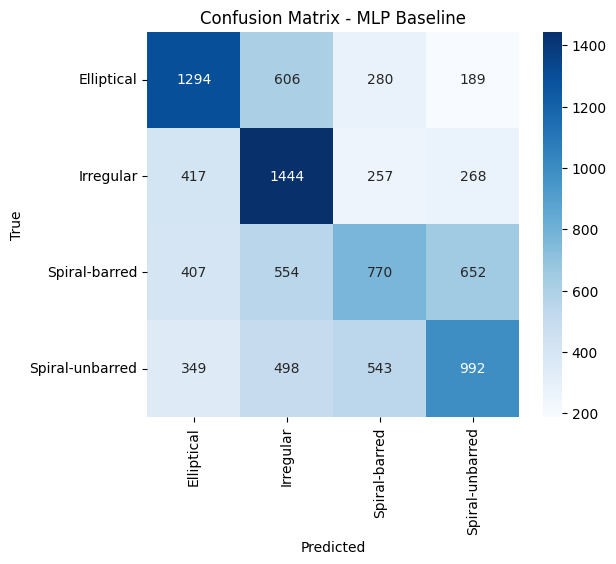

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_acc = model_m2b.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Predictions
y_pred = np.argmax(model_m2b.predict(X_test), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix - MLP Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Test Results Summary for `model_m2b`

**Test Accuracy:** 0.4727
**Test Loss:** 1.1704

**Classification Report:**
```
                 precision    recall  f1-score   support

     Elliptical       0.52      0.55      0.54      2369
      Irregular       0.47      0.61      0.53      2386
  Spiral-barred       0.42      0.32      0.36      2383
Spiral-unbarred       0.47      0.42      0.44      2382

       accuracy                           0.47      9520
      macro avg       0.47      0.47      0.47      9520
   weighted avg       0.47      0.47      0.47      9520
```